In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/mri_project/

/content/gdrive/MyDrive/mri_project


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/mri_project/"

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q /content/gdrive/MyDrive/mri_project/brain-tumor-classification-mri.zip -d .

replace ./Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install tensorflow_addons 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from typing import List
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from functools import partial
import posixpath
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from tensorflow.keras.models import Model

In [ ]:
train_loc= '/content/gdrive/MyDrive/mri_project/Training'
test_loc= '/content/gdrive/MyDrive/mri_project/Testing'


train_ds= tf.keras.utils.image_dataset_from_directory(train_loc,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        validation_split= 0.2,
                                                        subset="training",
                                                        image_size=(224, 224),
                                                        shuffle=True,
                                                        seed= 101,
                                                        batch_size= 32)

val_ds= tf.keras.utils.image_dataset_from_directory(train_loc,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        image_size=(224, 224),
                                                        shuffle=True,
                                                        seed= 101,
                                                        batch_size= 32)


test_gen= ImageDataGenerator()
test_ds= test_gen.flow_from_directory(test_loc,
                                            target_size= (224, 224),
                                            class_mode='categorical',
                                            batch_size= 32)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 images belonging to 4 classes.


In [ ]:
# Creating data augmentation layer

augmentation_layer= keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
])

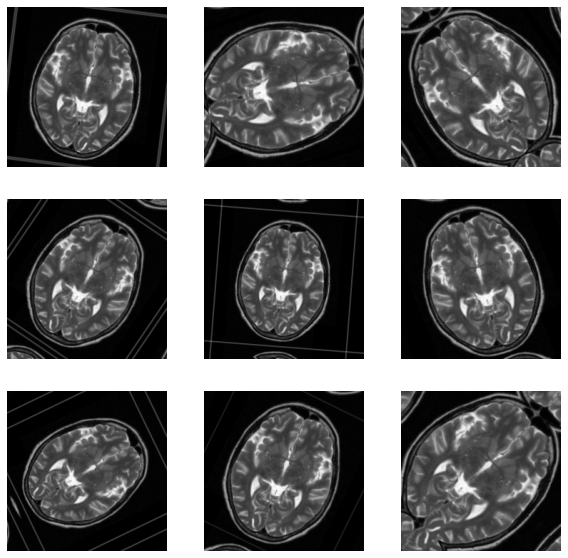

In [ ]:
# Checking augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        aug_img= augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_img[0].numpy().astype('int32'))
        plt.axis("off")

In [ ]:
AUTOTUNE= tf.data.AUTOTUNE

augmented_train_ds= train_ds.map(lambda x, y: (augmentation_layer(x), y))
train_final= augmented_train_ds.cache().prefetch(buffer_size= AUTOTUNE)
val_final= val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [ ]:
#conv_base2= tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top= False, weights='imagenet', pooling= None, include_preprocessing= True)
conv_base2= tf.keras.applications.efficientnet.EfficientNetB5(include_top = False,  weights = 'imagenet', pooling= None)
conv_base2.trainable= False

for l in conv_base2.layers:
    print(l.name, l.trainable)

115263384/115263384 [==============================] - 1s 0us/step
input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
bloc

In [ ]:


for layer in conv_base2.layers:
      if layer.name.startswith('block7') | layer.name.startswith('block6') | layer.name.startswith('block5') | layer.name.startswith('block4') | layer.name.startswith('block3') | layer.name.startswith('block2'):
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            
#pt_depth= conv_base2.get_output_shape_at(0)[-1]

for l in conv_base2.layers:
    print(l.name, l.trainable)

input_1 False
rescaling False
normalization False
tf.math.truediv False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block1c_dwconv False
block1c_bn False
block1c_activation False
block1c_se_squeeze False
block1c_se_reshape False
block1c_se_reduce False
block1c_se_expand False
block1c_se_excite False
block1c_project_conv False
block1c_project_bn False
block1c_drop False
block1c_add False
block2a_expand_conv True
block2a_expand_bn False
block2a_expand_activat

In [ ]:
inputs= layers.Input(shape = (224, 224, 3))
pre_process= tf.keras.applications.efficientnet.preprocess_input(inputs)
base_conv= conv_base2(pre_process)
bn= layers.BatchNormalization()(base_conv)

# Attention to turn pixels ON/OFF in Global Average Pooling
attn_layer= Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn)
attn_layer= Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer= LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
up_c2_w= np.ones((1, 1, 1, 2048))
up_c2= Conv2D(2048, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable= False
attn_layer= up_c2(attn_layer)
mask= multiply([attn_layer, bn])

# Global Average Pooling
gap_features= GlobalAveragePooling2D()(mask)
gap_mask= GlobalAveragePooling2D()(attn_layer)
gap= Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])
l= layers.Dropout(0.3)(gap)
l= layers.Dense(1024, activation = 'relu')(l)
l= layers.Dropout(0.4)(l)
outputs = layers.Dense(4, activation = 'softmax')(l)

model= tf.keras.Model(inputs= inputs, outputs= outputs)

In [ ]:
model.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= True),
loss = 'categorical_crossentropy', 
metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 4)]
)

In [ ]:
%%time

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only=True, mode= 'max')
callbacks_list=[checkpoint_callback]

history= model.fit(train_final,
                    epochs= 100,
                    validation_data= val_final,
                    callbacks= callbacks_list,
                    verbose= 1)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 0.9258 - accuracy: 0.6198 - f1_score: 0.6033
Epoch 1: val_accuracy improved from -inf to 0.77352, saving model to weights-improvement-01-0.7735.hdf5
72/72 [==============================] - 45s 376ms/step - loss: 0.9258 - accuracy: 0.6198 - f1_score: 0.6033 - val_loss: 0.6668 - val_accuracy: 0.7735 - val_f1_score: 0.7692
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7861 - f1_score: 0.7867
Epoch 2: val_accuracy improved from 0.77352 to 0.81533, saving model to weights-improvement-02-0.8153.hdf5
72/72 [==============================] - 21s 292ms/step - loss: 0.5765 - accuracy: 0.7861 - f1_score: 0.7867 - val_loss: 0.5204 - val_accuracy: 0.8153 - val_f1_score: 0.8187
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.8271 - f1_score: 0.8273
Epoch 3: val_accuracy improved from 0.81533 to 0.83275, saving model to weights-improvement-03-0.83

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.583832 to fit



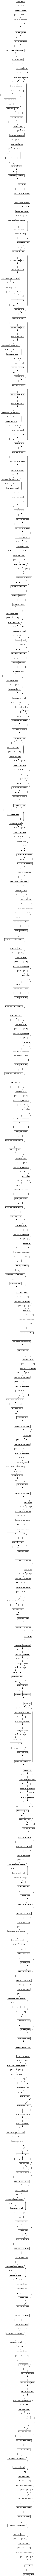

In [ ]:
tf.keras.utils.plot_model(conv_base2)

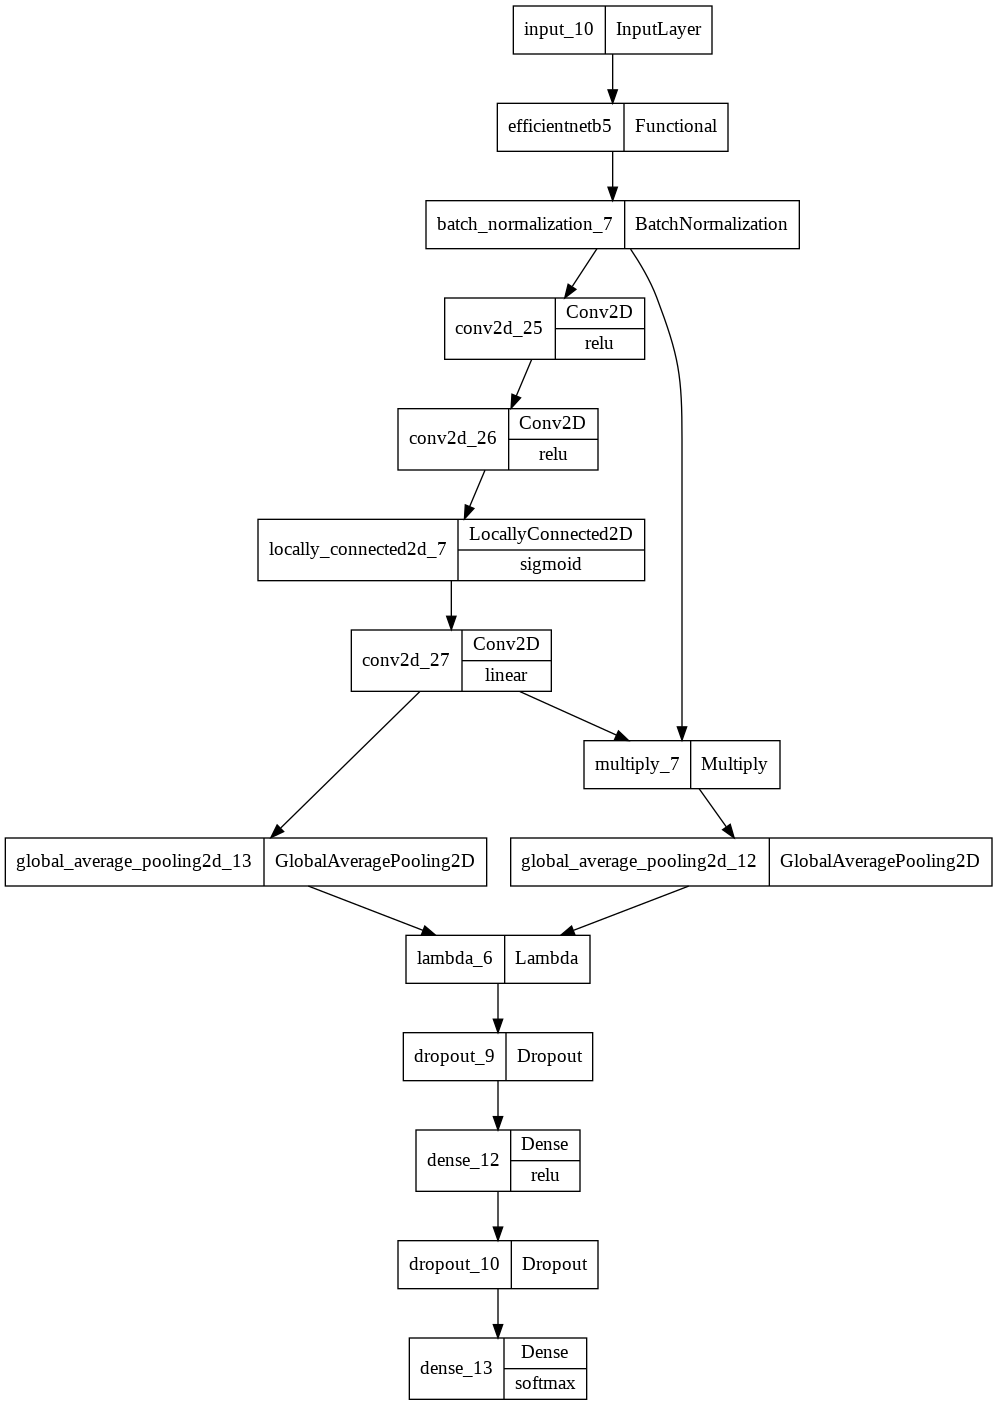

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_layer_names=True,
    show_layer_activations=True
)

In [ ]:
model_load= tf.keras.models.load_model('/content/gdrive/MyDrive/mri_project/weights-improvement-67-0.9373.hdf5')


In [ ]:
model_load.evaluate(val_ds, batch_size= 32)

18/18 [==============================] - 5s 217ms/step - loss: 0.2189 - accuracy: 0.9373 - f1_score: 0.9344


[0.2188582420349121, 0.9372822046279907, 0.9344159364700317]

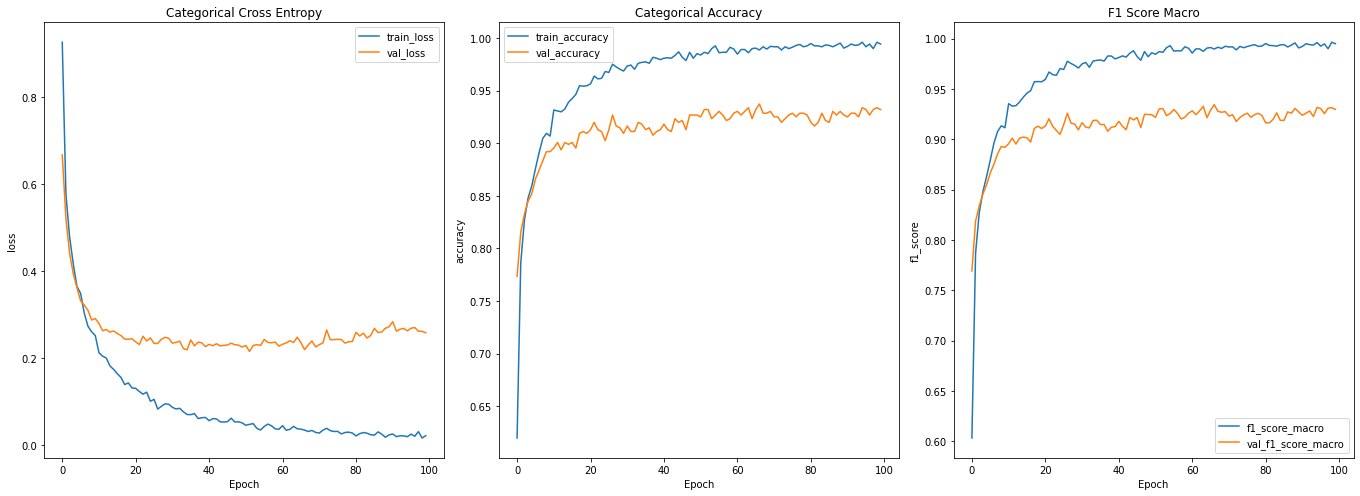

In [ ]:
def plot_results(history, epochs, FE_name= "ResNet50", model_name= "ResNet50_model", version= 1):
    import os
    ## Create the dataframe
    data = pd.DataFrame()
    data["Epoch"] = [i for i in range(epochs)]
    data["loss"] = history.history["loss"]
    data["val_loss"] = history.history["val_loss"]
    data["accuracy"] = history.history["accuracy"]
    data["val_accuracy"] = history.history["val_accuracy"]
    data["f1_score"] = history.history["f1_score"]
    data["val_f1_score"] = history.history["val_f1_score"]

    ## Create subplots
    fig, ax= plt.subplots(1, 3, figsize = (19, 7))

    ## plot loss
    sns.lineplot(x= "Epoch", y= "loss", data = data, ax= ax[0])
    sns.lineplot(x= "Epoch", y= "val_loss", data = data, ax= ax[0])
    ax[0].legend(["train_loss", "val_loss"], loc= 'best')
    ax[0].title.set_text("Categorical Cross Entropy")

    ## plot accuracy
    sns.lineplot(x = "Epoch", y = "accuracy", data = data, ax = ax[1])
    sns.lineplot(x = "Epoch", y = "val_accuracy", data = data, ax = ax[1])
    ax[1].legend(["train_accuracy", "val_accuracy"], loc='best')
    ax[1].title.set_text("Categorical Accuracy")

    ## plot f1
    sns.lineplot(x = "Epoch", y = "f1_score", data = data, ax = ax[2])
    sns.lineplot(x = "Epoch", y = "val_f1_score", data = data, ax = ax[2])
    ax[2].legend(["f1_score_macro", "val_f1_score_macro"], loc='best')
    ax[2].title.set_text("F1 Score Macro")


    ## Remove padding
    fig.tight_layout()

plot_results(history, epochs = 100, FE_name = "VGG16", model_name = "VGG16_exp1")

## Extra

In [ ]:
model_load.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb5 (Functional)    (None, None, None,   28513527    ['input_10[0][0]']               
                                2048)                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 7, 7, 2048)  8192        ['efficientnetb5[0][0]']         
 rmalization)                                                                               

In [ ]:
earlyPredictor= Model(model_load.inputs, model_load.layers['dense_12'].outputs)  

ValueError: ignored